/tmp/ipykernel_510432/1973326973.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/sandeep-sharma/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_510432/1973326973.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use mixed precision


Epoch 1/100 - Loss: 0.7419, Accuracy: 47.00%
Epoch 2/100 - Loss: 0.7326, Accuracy: 49.00%
Epoch 3/100 - Loss: 0.7238, Accuracy: 50.00%
Epoch 4/100 - Loss: 0.7153, Accuracy: 48.00%
Epoch 5/100 - Loss: 0.7073, Accuracy: 51.00%
Epoch 6/100 - Loss: 0.6998, Accuracy: 51.00%
Epoch 7/100 - Loss: 0.6926, Accuracy: 52.00%
Epoch 8/100 - Loss: 0.6859, Accuracy: 52.00%
Epoch 9/100 - Loss: 0.6796, Accuracy: 57.00%
Epoch 10/100 - Loss: 0.6736, Accuracy: 55.00%
Epoch 11/100 - Loss: 0.6681, Accuracy: 55.00%
Epoch 12/100 - Loss: 0.6630, Accuracy: 57.00%
Epoch 13/100 - Loss: 0.6582, Accuracy: 58.00%
Epoch 14/100 - Loss: 0.6538, Accuracy: 59.00%
Epoch 15/100 - Loss: 0.6496, Accuracy: 59.00%
Epoch 16/100 - Loss: 0.6458, Accuracy: 60.00%
Epoch 17/100 - Loss: 0.6423, Accuracy: 63.00%
Epoch 18/100 - Loss: 0.6390, Accuracy: 65.00%
Epoch 19/100 - Loss: 0.6360, Accuracy: 68.00%
Epoch 20/100 - Loss: 0.6332, Accuracy: 67.00%
Epoch 21/100 - Loss: 0.6305, Accuracy: 69.00%
Epoch 22/100 - Loss: 0.6281, Accuracy: 69.0

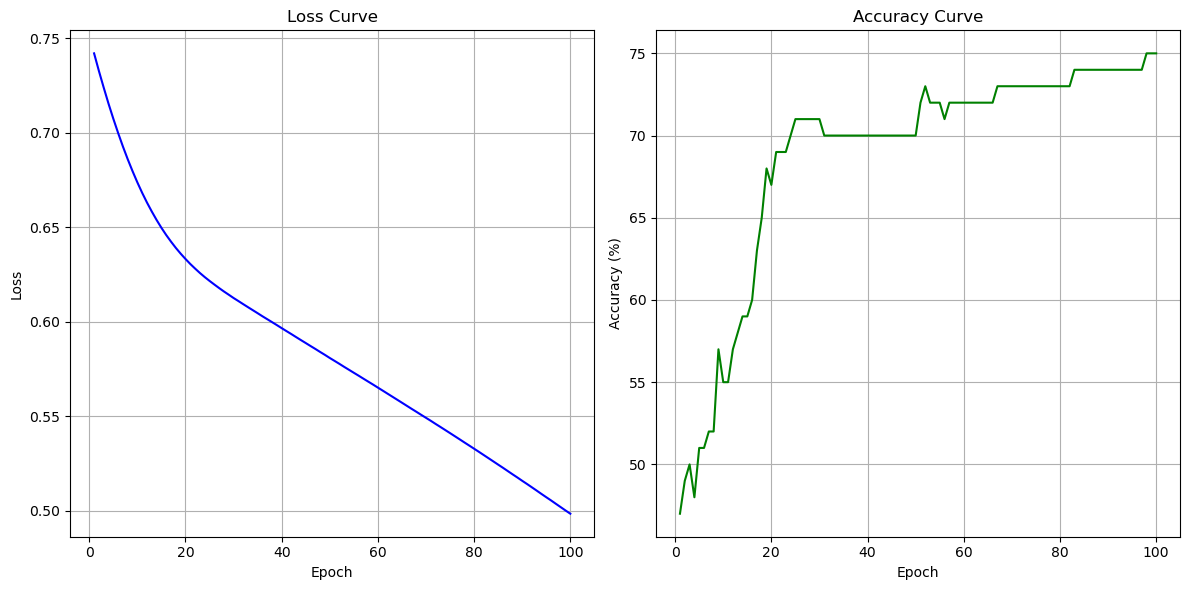

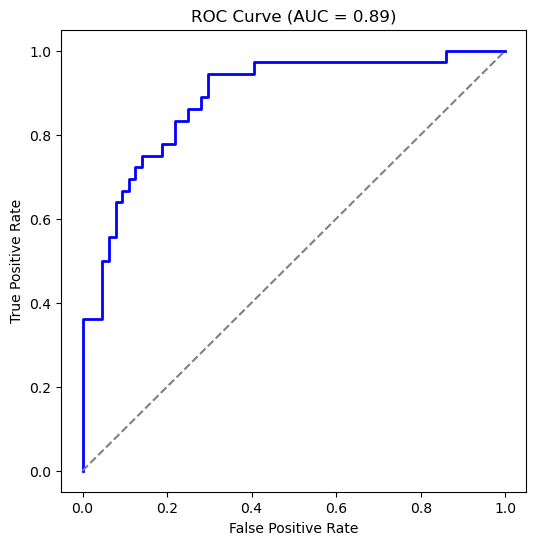

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data, DataLoader as GeoDataLoader
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Define your FC model (This is just an example for a simple model)
class FCModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)  # Adjust input_dim based on your features
        self.layer2 = nn.Linear(64, output_dim)  # Binary classification: signal vs background

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Initialize the model
input_dim = 10  # Adjust according to your feature size (e.g., 10 features per graph)
output_dim = 2  # Binary classification: signal or background
model = FCModel(input_dim, output_dim)

# Set up the device to use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU (if available)

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Initialize mixed precision scaler
scaler = GradScaler()

# Dummy dataset: replace with actual data loading process
features = torch.randn(100, 10)  # Example feature data (100 samples, 10 features)
labels = torch.randint(0, 2, (100,))  # Binary labels (0 for background, 1 for signal)

# Create graph data object (PyTorch Geometric expects edge_index as well)
edge_index = torch.randint(0, 100, (2, 200))  # Random example edges (100 nodes, 200 edges)

# Create Data object for PyTorch Geometric
data = Data(x=features, edge_index=edge_index, y=labels)

# Create DataLoader with small batch size to avoid memory issues
batch_size = 8  # Reduce batch size to fit into memory
train_loader = GeoDataLoader([data], batch_size=batch_size, shuffle=True)

# Initialize lists to store loss and accuracy for plotting
epoch_losses = []
epoch_accuracies = []

# Training loop with mixed precision
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for batch_data in train_loader:
        batch_data = batch_data.to(device)  # Move batch data to GPU
        
        # Clear gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast():  # Use mixed precision
            out = model(batch_data.x)  # Forward pass
            loss = loss_function(out, batch_data.y)  # Compute loss

        # Backward pass with scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        correct_predictions += (predicted == batch_data.y).sum().item()
        total_samples += batch_data.y.size(0)
        
        # Clear unused GPU memory
        torch.cuda.empty_cache()
    
    # Calculate average loss and accuracy for this epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)
    
    # Print loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Optionally, save model checkpoints every few epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"gnn_model_epoch_{epoch+1}.pth")

# After training, you can evaluate or further use the model
model.eval()
# Collect all true labels and predicted probabilities for ROC curve
true_labels = []
predicted_probs = []

# Inference with the entire dataset for ROC curve
for batch_data in train_loader:
    batch_data = batch_data.to(device)
    with torch.no_grad():
        out = model(batch_data.x)
        true_labels.extend(batch_data.y.cpu().numpy())
        predicted_probs.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())  # Get probabilities for class 1 (signal)

# Convert lists to numpy arrays for ROC
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_accuracies, label='Accuracy', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()


/tmp/ipykernel_510432/3259938628.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/sandeep-sharma/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_510432/3259938628.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use mixed precision


Epoch 1/10 - Loss: 0.6901, Accuracy: 52.00%
Epoch 2/10 - Loss: 0.6648, Accuracy: 54.00%
Epoch 3/10 - Loss: 0.6467, Accuracy: 60.00%
Epoch 4/10 - Loss: 0.6303, Accuracy: 63.00%
Epoch 5/10 - Loss: 0.6176, Accuracy: 69.00%
Epoch 6/10 - Loss: 0.6080, Accuracy: 69.00%
Epoch 7/10 - Loss: 0.5995, Accuracy: 69.00%
Epoch 8/10 - Loss: 0.5911, Accuracy: 69.00%
Epoch 9/10 - Loss: 0.5834, Accuracy: 69.00%
Epoch 10/10 - Loss: 0.5764, Accuracy: 70.00%


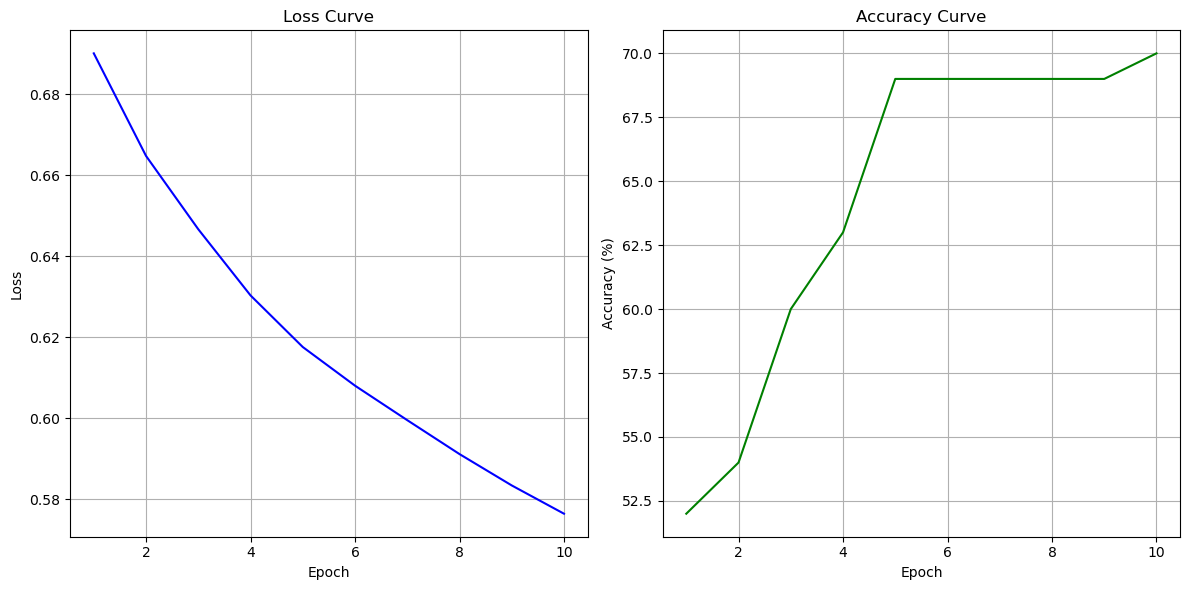

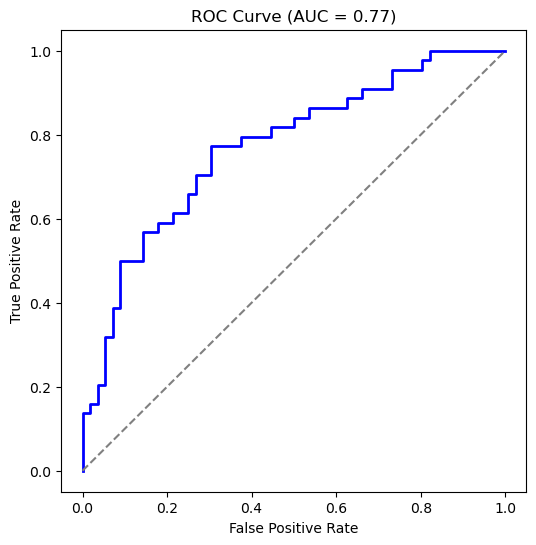

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data, DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Define your GNN model (GCN)
class GNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GNNModel, self).__init__()
        # Graph Convolutional Layers
        self.conv1 = GCNConv(input_dim, 64)  # First GCN layer
        self.conv2 = GCNConv(64, output_dim)  # Second GCN layer for output

    def forward(self, x, edge_index):
        # Apply graph convolution and ReLU activation
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
input_dim = 10  # Adjust according to your feature size (e.g., 10 features per graph)
output_dim = 2  # Binary classification: signal vs background
model = GNNModel(input_dim, output_dim)
# Set up the device to use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU (if available)

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

# Initialize mixed precision scaler
scaler = GradScaler()

# Dummy dataset: replace with actual data loading process
features = torch.randn(100, 10)  # Example feature data (100 samples, 10 features)
labels = torch.randint(0, 2, (100,))  # Binary labels (0 for background, 1 for signal)

# Create graph data object (PyTorch Geometric expects edge_index as well)
edge_index = torch.randint(0, 100, (2, 200))  # Random example edges (100 nodes, 200 edges)

# Create Data object for PyTorch Geometric
data = Data(x=features, edge_index=edge_index, y=labels)

# Create DataLoader with small batch size to avoid memory issues
batch_size = 8  # Reduce batch size to fit into memory
train_loader = GeoDataLoader([data], batch_size=batch_size, shuffle=True)

# Initialize lists to store loss and accuracy for plotting
epoch_losses = []
epoch_accuracies = []

# Training loop with mixed precision
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for batch_data in train_loader:
        batch_data = batch_data.to(device)  # Move batch data to GPU
        
        # Clear gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast():  # Use mixed precision
            out = model(batch_data.x, batch_data.edge_index)  # Forward pass
            loss = loss_function(out, batch_data.y)  # Compute loss

        # Backward pass with scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        correct_predictions += (predicted == batch_data.y).sum().item()
        total_samples += batch_data.y.size(0)
        
        # Clear unused GPU memory
        torch.cuda.empty_cache()
    
    # Calculate average loss and accuracy for this epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)
    
    # Print loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Optionally, save model checkpoints every few epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"gnn_model_epoch_{epoch+1}.pth")

# After training, you can evaluate or further use the model
model.eval()
# Collect all true labels and predicted probabilities for ROC curve
true_labels = []
predicted_probs = []

# Inference with the entire dataset for ROC curve
for batch_data in train_loader:
    batch_data = batch_data.to(device)
    with torch.no_grad():
        out = model(batch_data.x, batch_data.edge_index)
        true_labels.extend(batch_data.y.cpu().numpy())
        predicted_probs.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())  # Get probabilities for class 1 (signal)

# Convert lists to numpy arrays for ROC
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_accuracies, label='Accuracy', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()


In [13]:
model.parameters

<bound method Module.parameters of GNNModel(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 2)
)>
